## See how many GPUs we have

In [1]:
import torch

def check_gpu_memory_simple():
    if not torch.cuda.is_available():
        print("No available CUDA GPU")
        return
    
    for i in range(torch.cuda.device_count()):
        name = torch.cuda.get_device_name(i)
        total = torch.cuda.get_device_properties(i).total_memory / (1024 ** 3)  # GB
        allocated = torch.cuda.memory_allocated(i) / (1024 ** 3)  # GB
        free = (torch.cuda.get_device_properties(i).total_memory - torch.cuda.memory_reserved(i)) / (1024 ** 3)  # GB
        
        print(f"GPU {i} ({name}):")
        print(f"  Total Memory: {total:.2f} GB")
        print(f"  Used Memory: {allocated:.2f} GB")
        print(f"  Available Memory: {free:.2f} GB")

check_gpu_memory_simple()

GPU 0 (NVIDIA A10G):
  Total Memory: 21.99 GB
  Used Memory: 0.00 GB
  Available Memory: 21.99 GB


## Plot Expert load function

In [2]:
from collections import Counter
import matplotlib.pyplot as plt
import os
 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

def my_plot(topk_ids, selected=None, new_id=None):
    count = Counter(topk_ids.flatten().tolist())
    sorted_counts = sorted(count.items(), key=lambda x: x[0])
    elements = [k for k, v in sorted_counts]
    values = [v for k, v in sorted_counts] 
    colors = [  'skyblue' for v in values]
    if selected != None:
        for s in selected:
            colors[s] = 'green'
    if new_id!= None:
        for n in new_id:
            colors[n] = 'red'
    # 绘制柱状图
    plt.figure(figsize=(8, 5))
    plt.bar(elements, values, color=colors)
    plt.title('Frequency of Each Element', fontsize=14)
    plt.xlabel('Element', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    for i, value in enumerate(values):
        plt.text(elements[i], value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


## Initialize workers

In [3]:

from vllm.model_executor.layers.fused_moe.fused_moe import fused_experts_impl 
import transformers
from transformers import Qwen2MoeConfig 
import torch
import os

# 假设已经加载了 model
from transformers import AutoTokenizer, AutoModelForCausalLM

model_name = "Qwen/Qwen1.5-MoE-A2.7B"
config = transformers.AutoConfig.from_pretrained("Qwen/Qwen1.5-MoE-A2.7B")


WORLD_SIZE =  4
TOKEN_NUM= 1000
workers = [dict() for _ in range(WORLD_SIZE)]
for i in range(0,len(workers)):
    workers[i]["world_size"] = WORLD_SIZE
    workers[i]["rank"] =   i
print(workers)
 


/home/ubuntu/vllm_test_field/myvllm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 05-11 03:39:16 [__init__.py:239] Automatically detected platform cuda.


2025-05-11 03:39:17,146	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


[{'world_size': 4, 'rank': 0}, {'world_size': 4, 'rank': 1}, {'world_size': 4, 'rank': 2}, {'world_size': 4, 'rank': 3}]


## Create Docker Image for future use

In [4]:
! docker build -t moe_expert ~/vllm_test_field/vllm/flask_docker_app/.

[+] Building 0.0s (0/1)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s


[+] Building 0.2s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 851B                                       0.0s
 => [internal] load metadata for docker.io/nvidia/cuda:12.1.1-base-ubuntu  0.2s
[+] Building 0.2s (2/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 851B                                       0.0s
 => [internal] load metadata for docker.io/nvidia/cuda:12.1.1-base-ubuntu  0.2s
[+] Building 0.3s (11/11) FINISHED                               docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 851B                                       0.0s
 => [internal] load metadata for docker.io/nvidia/cuda:12.1.1-base-ubuntu  0.2s
 => [internal] load .dockerignore       

## Initialize rank weight in the original track

In [5]:
def init_rank_weight(world_size, config ):
    expert_num = config.num_experts
    avg_expert = expert_num // world_size
    w13_weight = torch.nn.Parameter(torch.randn(
            avg_expert,
            2 * config.moe_intermediate_size,
        config.hidden_size,
        dtype=torch.bfloat16), requires_grad=False).to("cuda")
    print(w13_weight.shape)
    w2_weight =torch.nn.Parameter(torch.randn(
        avg_expert,
        config.hidden_size,
        config.moe_intermediate_size ,
        dtype=torch.bfloat16),
        requires_grad=False).to("cuda")
    print(w2_weight.shape) 
    return w13_weight, w2_weight

for worker in workers:
    worker["w1"] , worker["w2"] = init_rank_weight(WORLD_SIZE, config)
# ----------------------------------------original code above--------------------------------------

import subprocess
import time
import torch
# configs
torch.cuda.empty_cache()
torch.cuda.synchronize()
NUM_CONTAINERS = WORLD_SIZE
IMAGE_NAME = "moe_expert"
layer = 23
experts_count_per_container = 60//NUM_CONTAINERS

start_time = time.time() 

for i in range(NUM_CONTAINERS):
    cmd = [
    "docker", "run", "-d",
    "--name", f"fused_moe_layer_{layer}_exp_{i*experts_count_per_container}_{(i+1)*experts_count_per_container-1}",
    "--gpus", "all",
    "--rm",
    "-p", f"{5000+i}:5000",
    "-v", "/home/ubuntu/vllm_test_field/vllm/ipc_handler_demo/weights:/app/weights",
    "-e", f"RANK={i}",
    "-e", f"NUM_EXPERTS={experts_count_per_container}",
    "-e", f"GPU_IDX={0}",
    "-e", f"WEIGHT_PATH=/app/weights",
    "-e", f"LAYER={layer}",
    
    IMAGE_NAME
    ]
    try:
        subprocess.run(cmd, check=True)
        print(f"fused_moe_layer_{layer}_exp_{i*experts_count_per_container}_{(i+1)*experts_count_per_container-1}\n容器启动成功！")
    except subprocess.CalledProcessError as e:
        print(f"启动失败: {e}")
        

end_time = time.time()  # 记录结束时间
elapsed_time = end_time - start_time  # 计算用时
print(f"Containers launched in: {elapsed_time*1000:.2f} ms")
print(f"Average containers launching time : {elapsed_time*1000/WORLD_SIZE:.2f} ms")

torch.Size([15, 2816, 2048])
torch.Size([15, 2048, 1408])
torch.Size([15, 2816, 2048])
torch.Size([15, 2048, 1408])
torch.Size([15, 2816, 2048])
torch.Size([15, 2048, 1408])
torch.Size([15, 2816, 2048])
torch.Size([15, 2048, 1408])
801053b8af746b2fc27637a6e1d53f1e0cac49d42ce71eb56e18516d39939972
fused_moe_layer_23_exp_0_14
容器启动成功！
9c0ed00934f75401a5f7f7c171098f11a8d85a876bb77e29243b238933d78614
fused_moe_layer_23_exp_15_29
容器启动成功！
87a5a175be4a5a201bd240de5c680acde7e6e005549d83791111222584c73590
fused_moe_layer_23_exp_30_44
容器启动成功！
3d6b886794f3fc344a525e8e6c089bed0121bc05aa4e754537d0a55186d5da2f
fused_moe_layer_23_exp_45_59
容器启动成功！
Containers launched in: 1927.85 ms
Average containers launching time : 481.96 ms


## Prepare input for normal vllm track and expert-duplication containers

In [6]:


def create_input(token_num, config):
    topk_ids = torch.randint(0, config.num_experts, (token_num, config.num_experts_per_tok), dtype=torch.int32).to("cuda")
    topk_weights = torch.randn(token_num, config.num_experts_per_tok, dtype=torch.float32).to("cuda")
    hidden_states = torch.randn( token_num, config.hidden_size, dtype=torch.bfloat16).to("cuda") # 
    print("topk_ids.shape", topk_ids.shape, topk_ids.dtype)
    print("topk_weights.shape", topk_weights.shape, topk_weights.dtype)
    print("hidden_states.shape", hidden_states.shape, hidden_states.dtype)
    return {"topk_ids":topk_ids,"topk_weights":topk_weights, "hidden_states":hidden_states }

inputs = create_input( TOKEN_NUM, config)


# ----------------------------------------original code above--------------------------------------

def create_input_container(token_num, config):
    topk_ids = inputs["topk_ids"].clone().cpu()
    topk_weights = inputs["topk_weights"].clone().cpu()
    hidden_states = inputs["hidden_states"].clone().cpu() # 
    print("topk_ids.shape", topk_ids.shape, topk_ids.dtype)
    print("topk_weights.shape", topk_weights.shape, topk_weights.dtype)
    print("hidden_states.shape", hidden_states.shape, hidden_states.dtype)
    return {"topk_ids":topk_ids.tolist(),"topk_weights":topk_weights.tolist(), "hidden_states":hidden_states.tolist() }

inputs_container = create_input_container( TOKEN_NUM, config)

topk_ids.shape torch.Size([1000, 4]) torch.int32
topk_weights.shape torch.Size([1000, 4]) torch.float32
hidden_states.shape torch.Size([1000, 2048]) torch.bfloat16
topk_ids.shape torch.Size([1000, 4]) torch.int32
topk_weights.shape torch.Size([1000, 4]) torch.float32
hidden_states.shape torch.Size([1000, 2048]) torch.bfloat16


## Initialize expert map for boths path

In [7]:
def init_expert_map(rank, world_size, total_expert_num):
    avg_expert_num = total_expert_num // world_size
    real_local_expert_ids = list(range(rank * avg_expert_num, (rank + 1) * avg_expert_num))
    expert_map = [-1] * total_expert_num
    for local_id, global_id in enumerate(real_local_expert_ids):
        expert_map[global_id] = local_id
    return torch.tensor(expert_map, device="cuda", dtype=torch.int32)

for worker in workers:
    worker["expert_map"]  = init_expert_map( worker["rank"],WORLD_SIZE,  config.num_experts)
    print(worker["expert_map"], worker["expert_map"].shape)
    
 
 # ----------------------------------------original code above--------------------------------------   

for worker in workers:
    worker["expert_map"]  = init_expert_map( worker["rank"],WORLD_SIZE,  config.num_experts)
    # 创建包含60个-1的Tensor
    minus_ones = torch.full((60,), -1).cuda()
    worker["expert_map"]  = torch.cat((worker["expert_map"] ,minus_ones))
    print(worker["expert_map"], worker["expert_map"].shape)


print("\ncontainer expert maps\n\n")
container_expert_maps=[]
for worker in workers:
    em  = init_expert_map( worker["rank"],WORLD_SIZE,  config.num_experts)
    # 创建包含60个-1的Tensor
    minus_ones = torch.full((60,), -1).cuda()
    em  = torch.cat((minus_ones,em))
    print(em, em.shape)
    container_expert_maps.append(em.cpu().tolist())



tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1], device='cuda:0', dtype=torch.int32) torch.Size([60])
tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,
         3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1], device='cuda:0', dtype=torch.int32) torch.Size([60])
tensor([-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  0,  1,  2,  3,  4,  5,
         6,  7,  8,  9, 10, 11, 12, 13, 14, -1, -1, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1, -1, -1, -1], device='cuda:0', dtype=torch.int32) torch.Size([60])
tensor([-1, -1, -1, -1

## Warm up

In [8]:
def moe_forward(worker, inputs ):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()
    output = fused_experts_impl(
        hidden_states = inputs["hidden_states"],
        w1 = worker["w1"],
        w2 = worker["w2"],
        topk_weights = inputs["topk_weights"],
        topk_ids = inputs["topk_ids"],
        inplace = True,
        activation = "silu",
        expert_map = worker["expert_map"],
        global_num_experts =worker["expert_map"].shape[0]
    )
    end_event.record()
    torch.cuda.synchronize()
    latency_ms = start_event.elapsed_time(end_event)
    return output,latency_ms

make_inputs={"topk_ids": torch.randint(low=0, high=60, size=inputs["topk_ids"].shape, dtype=inputs["topk_ids"].dtype,device=inputs["topk_ids"].device),
             "topk_weights": torch.rand_like(inputs["topk_weights"], dtype=inputs["topk_weights"].dtype,device=inputs["topk_weights"].device),
             "hidden_states": torch.rand_like(inputs["hidden_states"], dtype=inputs["hidden_states"].dtype,device=inputs["hidden_states"].device)}

for worker in workers:
    moe_forward (worker, make_inputs)

WARNING 05-11 03:39:35 [fused_moe.py:954] Using default MoE config. Performance might be sub-optimal! Config file not found at /home/ubuntu/vllm_test_field/vllm/vllm/model_executor/layers/fused_moe/configs/E=15,N=1408,device_name=NVIDIA_A10G.json
INFO 05-11 03:39:35 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])


INFO 05-11 03:39:35 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])
INFO 05-11 03:39:35 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])
INFO 05-11 03:39:35 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])


## without expert duplication

In [9]:
inputs["hidden_states"].shape

torch.Size([1000, 2048])

In [10]:




without_expert_duplication_time_cost=[]
for worker in workers:
    worker["output"],latency_ms = moe_forward (worker, inputs)
    without_expert_duplication_time_cost.append(latency_ms)
    print(worker["output"].shape)

for i in range(len(without_expert_duplication_time_cost)):
    print(f"Rank {i} latency: {without_expert_duplication_time_cost[i]} ms")



INFO 05-11 03:39:36 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])
torch.Size([1000, 2048])
INFO 05-11 03:39:36 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])
torch.Size([1000, 2048])
INFO 05-11 03:39:36 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])
torch.Size([1000, 2048])
INFO 05-11 03:39:36 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])
torch.Size([1000, 2048])
Rank 0 latency: 3.1498239040374756 ms
Rank 1 latency: 2.213887929916382 ms
Rank 2 latency: 3.4856960773468018 ms
Rank 3 latency: 5.307392120361328 ms


## Wait for containers to be fully initialized

In [11]:
time.sleep(10)

## Pure using container

In [12]:
# container warmup
import requests
token_num=1000
make_inputs_container={"topk_ids": torch.randint(0, config.num_experts, (token_num, config.num_experts_per_tok), dtype=torch.int32).cpu().tolist(),
             "topk_weights": torch.randn(token_num, config.num_experts_per_tok, dtype=torch.float32).cpu().tolist(),
             "hidden_states": torch.randn( token_num, config.hidden_size, dtype=torch.bfloat16).cpu().tolist()}

for i in range(WORLD_SIZE):
    url = f"http://localhost:500{i}/forward"
    response = requests.post(url, json=make_inputs_container)
    output = torch.tensor(response.json()["hidden_output"],dtype=torch.bfloat16,device="cuda:0")


In [13]:
out_hidden_states = []
for i in range(WORLD_SIZE):
    url = f"http://localhost:500{i}/forward"
    response = requests.post(url, json=inputs_container)

    output = torch.tensor(response.json()["hidden_output"],dtype=torch.bfloat16,device="cuda:0")
    latency_ms = response.json()["latency_ms"]
    print(f"Container {i} latency: {latency_ms} ms")
    print("output.shape", output.shape)
    out_hidden_states.append(output)

Container 0 latency: 1.3482880592346191 ms
output.shape torch.Size([1000, 2048])
Container 1 latency: 1.2819520235061646 ms
output.shape torch.Size([1000, 2048])
Container 2 latency: 1.2655999660491943 ms
output.shape torch.Size([1000, 2048])
Container 3 latency: 1.3551360368728638 ms
output.shape torch.Size([1000, 2048])


## Plot expert load

/tmp/ipykernel_8639/378252664.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  my_plot(torch.tensor(inputs["topk_ids"]))


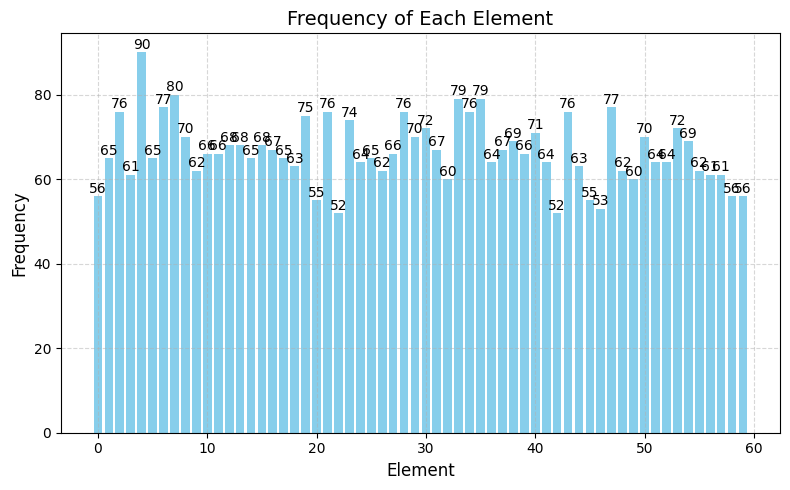

In [14]:
my_plot(torch.tensor(inputs["topk_ids"]))

## Load balance

In [15]:


# def select_expert(topk_ids):
#     # return expert_id, max_token_num
#     count = Counter(topk_ids.flatten().tolist())
#     sorted_counts_cnt = sorted(count.items(), key=lambda x: x[1],reverse=True)
#     print(f"selected_id {sorted_counts_cnt[0][0]}, max_token_num { sorted_counts_cnt[0][1]}"  )
#     return sorted_counts_cnt[0][0], sorted_counts_cnt[0][1]
# selected_id, max_token_num = select_expert(inputs["topk_ids"])

# ----------------------------------------original code above--------------------------------------
def select_expert(topk_ids):
    # return expert_id, max_token_num
    counts = Counter(topk_ids.flatten().tolist())
    sorted_counts_cnt = sorted(counts.items(), key=lambda x: x[1],reverse=True)
    average =( sum(counts.values())+1) // len(counts.values())
    
    print(f"The average experts load is: {average}")

    exceeded_loads = {k: (v - average if v > average else 0) for k, v in sorted_counts_cnt}
    return exceeded_loads,average

exceeded_expert_load,average_load = select_expert(torch.tensor(inputs["topk_ids"]).cpu())
print("exceeded_expert_load: ", sorted(exceeded_expert_load.items(), key=lambda x: x[0],reverse=False))
print("total exceeded_expert_load: ", sum(exceeded_expert_load.values()))
print("max load in exceeded_expert_load: ", max(exceeded_expert_load.values()))


The average experts load is: 66
exceeded_expert_load:  [(0, 0), (1, 0), (2, 10), (3, 0), (4, 24), (5, 0), (6, 11), (7, 14), (8, 4), (9, 0), (10, 0), (11, 0), (12, 2), (13, 2), (14, 0), (15, 2), (16, 1), (17, 0), (18, 0), (19, 9), (20, 0), (21, 10), (22, 0), (23, 8), (24, 0), (25, 0), (26, 0), (27, 0), (28, 10), (29, 4), (30, 6), (31, 1), (32, 0), (33, 13), (34, 10), (35, 13), (36, 0), (37, 1), (38, 3), (39, 0), (40, 5), (41, 0), (42, 0), (43, 10), (44, 0), (45, 0), (46, 0), (47, 11), (48, 0), (49, 0), (50, 4), (51, 0), (52, 0), (53, 6), (54, 3), (55, 0), (56, 0), (57, 0), (58, 0), (59, 0)]
total exceeded_expert_load:  197
max load in exceeded_expert_load:  24


/tmp/ipykernel_8639/2741822451.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  exceeded_expert_load,average_load = select_expert(torch.tensor(inputs["topk_ids"]).cpu())


In [16]:
# def get_new_map(rank, world_size, total_expert_num, selected_id):
#     avg_expert_num = total_expert_num // world_size
#     real_local_expert_ids = list(range(rank * avg_expert_num, (rank + 1) * avg_expert_num))
#     expert_map = [-1] * (total_expert_num+1)
#     for local_id, global_id in enumerate(real_local_expert_ids):
#         expert_map[global_id] = local_id
#     if selected_id in real_local_expert_ids:
#         expert_map[-1] =  len(real_local_expert_ids)
#     return torch.tensor(expert_map, device="cuda", dtype=torch.int32)

# for i in range(0,WORLD_SIZE):
#     new_expert_map  = get_new_map(
#         i,WORLD_SIZE,config.num_experts, selected_id
#     )
#     workers[i]["new_expert_map"] = new_expert_map
#     print(new_expert_map, new_expert_map.shape)




## modify weight in the original track(not needed)

In [17]:
# def get_new_weight( w1,w2, rank,  selected_id, expert_map ):
#     local_idx = expert_map [selected_id]
#     if local_idx == -1:
#         print(f"[Rank {rank}]: Selected expert {selected_id} not in local expert_map. Skip.")
#         return w1, w2
#     else:
#         # replicate expert
#         print(f"[Rank {rank}]: Replicating expert {selected_id}, local_idx: {local_idx}")
#         # extract and append the expert weights
#         new_expert_w1 = w1[local_idx].unsqueeze(0)  
#         new_expert_w2 = w2[local_idx].unsqueeze(0)
#         # concat new expert w1 to w1
#         new_w1 = torch.cat((w1, new_expert_w1.to(w1.device)), dim=0)
#         new_w2 = torch.cat((w2, new_expert_w2.to(w2.device)), dim=0)
#         print(f"[Rank {rank}]: New w1 shape: {new_w1.shape}")
#         print(f"[Rank {rank}]: New w2 shape: {new_w2.shape}")
#         return new_w1, new_w2
# for i in range(0,WORLD_SIZE):
#     new_w1, new_w2 = get_new_weight(
#         workers[i]["w1"],
#         workers[i]["w2"],
#         i,
#         selected_id,
#         workers[i]["new_expert_map"]
#     )
#     workers[i]["new_w1"] = new_w1
#     workers[i]["new_w2"] = new_w2

## modify topk ids with both local and containers

In [18]:
inputs["topk_ids"]

tensor([[50, 19,  5, 12],
        [ 7, 23, 39, 38],
        [ 2, 28, 40, 12],
        ...,
        [ 6, 45, 55, 48],
        [28, 12, 16, 49],
        [ 6, 30,  5, 47]], device='cuda:0', dtype=torch.int32)

In [19]:
from collections import defaultdict

def modify_topk_ids_container(topk_ids, expert_num):

    # 将一半 selected_id 的 workload 转移给新 expert
    cnt = defaultdict(int)
    
    for i in range(len(topk_ids)):
        for j in range(len(topk_ids[0])):
            if cnt[topk_ids[i][j]] <= average_load:
                cnt[topk_ids[i][j]] += 1
            else:
                print(f"{int(topk_ids[i][j])} -> {int(topk_ids[i][j]+expert_num)}")
                topk_ids[i][j] = expert_num + topk_ids[i][j]
                
           

    return topk_ids
newly_generated_topk_ids = modify_topk_ids_container(inputs_container["topk_ids"], 60)

4 -> 64
4 -> 64
4 -> 64
4 -> 64
4 -> 64
4 -> 64
4 -> 64
4 -> 64
33 -> 93
33 -> 93
19 -> 79
33 -> 93
4 -> 64
7 -> 67
19 -> 79
35 -> 95
35 -> 95
7 -> 67
34 -> 94
7 -> 67
35 -> 95
19 -> 79
4 -> 64
7 -> 67
7 -> 67
47 -> 107
23 -> 83
4 -> 64
23 -> 83
47 -> 107
4 -> 64
47 -> 107
33 -> 93
7 -> 67
34 -> 94
28 -> 88
19 -> 79
23 -> 83
7 -> 67
35 -> 95
4 -> 64
47 -> 107
28 -> 88
7 -> 67
34 -> 94
28 -> 88
34 -> 94
23 -> 83
47 -> 107
6 -> 66
6 -> 66
47 -> 107
28 -> 88
43 -> 103
4 -> 64
35 -> 95
4 -> 64
35 -> 95
43 -> 103
2 -> 62
4 -> 64
35 -> 95
21 -> 81
4 -> 64
6 -> 66
15 -> 75
28 -> 88
43 -> 103
2 -> 62
34 -> 94
33 -> 93
47 -> 107
21 -> 81
35 -> 95
40 -> 100
6 -> 66
19 -> 79
7 -> 67
19 -> 79
30 -> 90
35 -> 95
28 -> 88
21 -> 81
4 -> 64
7 -> 67
4 -> 64
28 -> 88
35 -> 95
34 -> 94
7 -> 67
34 -> 94
2 -> 62
33 -> 93
28 -> 88
8 -> 68
34 -> 94
8 -> 68
6 -> 66
2 -> 62
2 -> 62
23 -> 83
6 -> 66
40 -> 100
2 -> 62
33 -> 93
53 -> 113
23 -> 83
4 -> 64
40 -> 100
33 -> 93
47 -> 107
33 -> 93
6 -> 66
34 -> 94
19 ->

In [20]:
# def modify_topk_ids(topk_ids, selected_id, token_num, expert_num):
#     topk_ids = topk_ids.clone()
#     # 将一半 selected_id 的 workload 转移给新 expert
#     cnt = 0
#     new_expert_id = expert_num
#     for i in range(topk_ids.shape[0]):
#         for j in range(topk_ids.shape[1]):
#             if topk_ids[i][j] == selected_id:
#                 topk_ids[i][j] = new_expert_id
#                 print(f"{selected_id} -> {new_expert_id}")
#                 cnt += 1
#                 if cnt >= token_num // 2:
#                     break
#         if cnt >= token_num // 2:
#             break

#     return topk_ids, new_expert_id

# inputs["new_topk_ids"] ,new_expert_id= modify_topk_ids(inputs["topk_ids"],selected_id,max_token_num, config.num_experts )

In [21]:
inputs["new_topk_ids"]= torch.tensor(newly_generated_topk_ids,dtype=torch.int32).to("cuda")
print(inputs["new_topk_ids"].shape)
worker["expert_map"].shape

torch.Size([1000, 4])


torch.Size([120])

## with expert duplication

In [22]:

def new_moe_forward(worker, inputs ):
    start_event = torch.cuda.Event(enable_timing=True)
    end_event = torch.cuda.Event(enable_timing=True)
    start_event.record()
    output = fused_experts_impl(
        hidden_states = inputs["hidden_states"],
        w1 = worker["w1"],
        w2 = worker["w2"],
        topk_weights = inputs["topk_weights"],
        topk_ids = inputs["new_topk_ids"],
        inplace = True,
        activation = "silu",
        expert_map =worker["expert_map"]  ,
        global_num_experts =worker["expert_map"].shape[0]
    )
    end_event.record()
    torch.cuda.synchronize()
    latency_ms = start_event.elapsed_time(end_event)
    return output,latency_ms
local_latency_with_expert_duplication_time_cost=[]
for worker in workers:
    worker["new_output"],latency_ms = new_moe_forward (worker, inputs)
    local_latency_with_expert_duplication_time_cost.append(latency_ms)
    print(worker["new_output"].shape)
    print("latency_ms", latency_ms)

INFO 05-11 03:40:14 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])
torch.Size([1000, 2048])
latency_ms 2.540544033050537
INFO 05-11 03:40:14 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])
torch.Size([1000, 2048])
latency_ms 1.6261119842529297
INFO 05-11 03:40:14 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])
torch.Size([1000, 2048])
latency_ms 1.6066559553146362
INFO 05-11 03:40:14 [fused_moe.py:1658] expert_ids.shape: torch.Size([181])
torch.Size([1000, 2048])
latency_ms 1.6373759508132935


In [23]:
for i in workers:
    print(torch.equal(
        i["new_output"], i["output"]
    ))

True
True
True
True


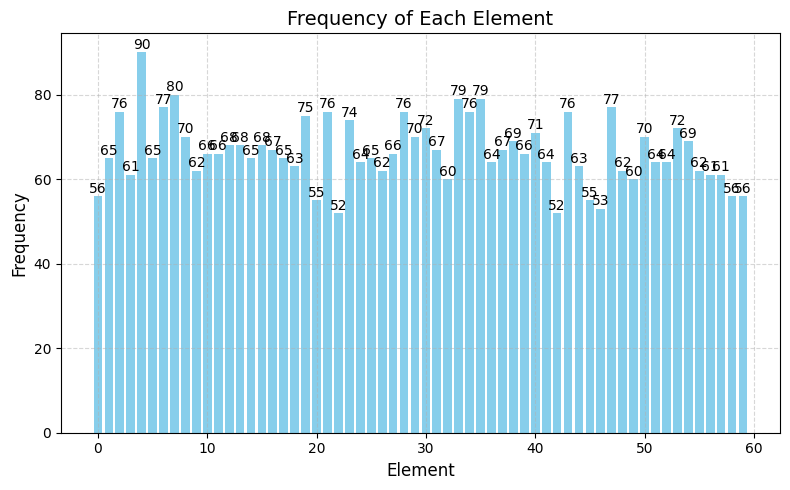

In [24]:
my_plot(inputs["topk_ids"] )


In [25]:
selected_ids=[k for k,v in exceeded_expert_load.items() if v!=0]
new_expert_ids=[i+60 for i in selected_ids]
for s,n in zip(selected_ids,new_expert_ids):
    print(f"{s} -> {n}")
len(new_expert_ids)

4 -> 64
7 -> 67
33 -> 93
35 -> 95
6 -> 66
47 -> 107
2 -> 62
28 -> 88
43 -> 103
21 -> 81
34 -> 94
19 -> 79
23 -> 83
30 -> 90
53 -> 113
40 -> 100
50 -> 110
29 -> 89
8 -> 68
38 -> 98
54 -> 114
12 -> 72
13 -> 73
15 -> 75
16 -> 76
37 -> 97
31 -> 91


27

## plot the experts load 

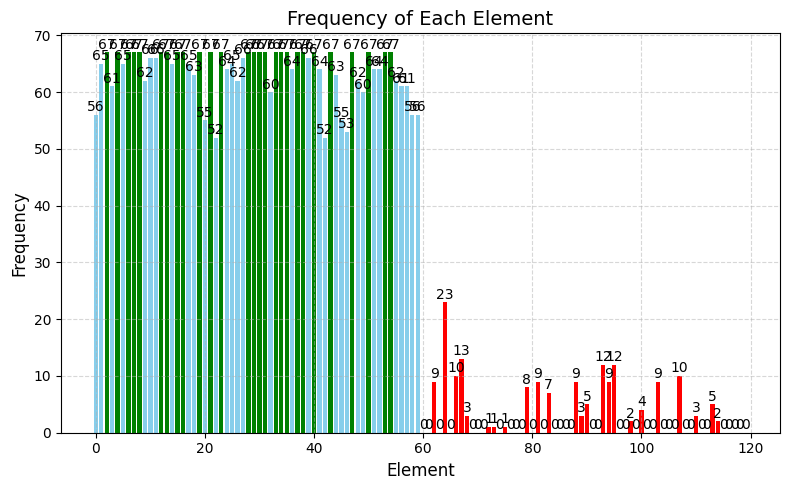

In [26]:
def my_plot(topk_ids, selected=None, new_id=None):
    count = Counter(topk_ids.flatten().tolist())
    count = Counter({k: count.get(k, 0) for k in range(120)})
    
    sorted_counts = sorted(count.items(), key=lambda x: x[0])
    elements = [k for k, v in sorted_counts]
    values = [v for k, v in sorted_counts] 
    colors = [  'skyblue' for v in range(120)]
    if selected != None:
        for s in selected:
            colors[s] = 'green'
    if new_id!= None:
        for n in new_id:
            colors[n] = 'red'
    # 绘制柱状图
    plt.figure(figsize=(8, 5))
    plt.bar(elements, values, color=colors)
    plt.title('Frequency of Each Element', fontsize=14)
    plt.xlabel('Element', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    for i, value in enumerate(values):
        plt.text(elements[i], value + 0.1, str(value), ha='center', va='bottom', fontsize=10)

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
my_plot(inputs["new_topk_ids"], selected_ids, new_expert_ids)


In [27]:
inputs_container.keys()

dict_keys(['topk_ids', 'topk_weights', 'hidden_states'])

In [28]:
inputs_container["topk_ids"]=newly_generated_topk_ids


In [29]:
import requests
out_hidden_states = []
container_latency_with_expert_duplication_time_cost=[]
for i in range(WORLD_SIZE):
    url = f"http://localhost:500{i}/forward"
    inputs_container["expert_map"] = container_expert_maps[i]
    response = requests.post(url, json=inputs_container)

    output = torch.tensor(response.json()["hidden_output"],dtype=torch.bfloat16,device="cuda:0")
    latency_ms = response.json()["latency_ms"]
    container_latency_with_expert_duplication_time_cost.append(latency_ms)
    print(f"Container {i} latency: {latency_ms} ms")
    print("output.shape", output.shape)
    out_hidden_states.append(output)


Container 0 latency: 1.3375359773635864 ms
output.shape torch.Size([1000, 2048])
Container 1 latency: 1.2739839553833008 ms
output.shape torch.Size([1000, 2048])
Container 2 latency: 1.2752959728240967 ms
output.shape torch.Size([1000, 2048])
Container 3 latency: 1.3663359880447388 ms
output.shape torch.Size([1000, 2048])


## Plot time usage

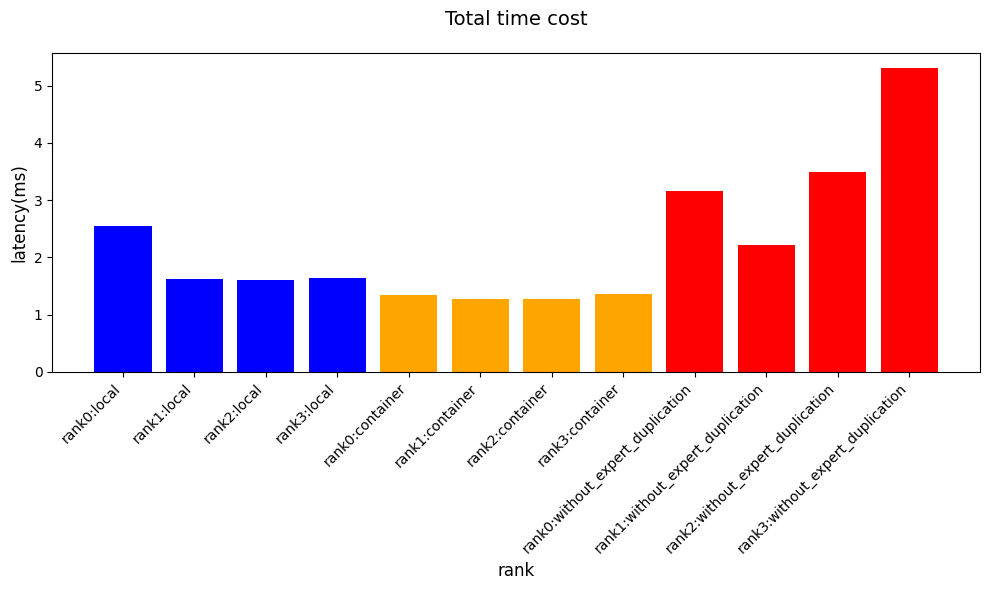

In [30]:
import matplotlib.pyplot as plt
from collections import Counter

xaxis_label=["rank0:local","rank1:local","rank2:local","rank3:local",
             "rank0:container","rank1:container","rank2:container","rank3:container",
             "rank0:without_expert_duplication",
             "rank1:without_expert_duplication","rank2:without_expert_duplication","rank3:without_expert_duplication"]
# Sample data with string keys
value = local_latency_with_expert_duplication_time_cost + container_latency_with_expert_duplication_time_cost+without_expert_duplication_time_cost
data = {k: v for k, v in zip(xaxis_label, value)}

# Custom colors for each bar (can use color names or hex codes)
bar_colors = ['blue']*4+['orange']*4+['red']*4

# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot bars with custom colors
bars = ax.bar(data.keys(), data.values(), color=bar_colors)

# Customize the plot
ax.set_title('Total time cost', fontsize=14, pad=20)
ax.set_ylabel('latency(ms)', fontsize=12)
ax.set_xlabel('rank', fontsize=12)

# Rotate x-axis labels if needed
plt.xticks(rotation=45, ha='right')

# # Add value labels on top of each bar
# for bar in bars:
#     height = bar.get_height()
#     ax.text(bar.get_x() + bar.get_width()/2., height,
#             f'{height:.2f}',
#             ha='center', va='bottom')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show the plot
plt.show()